# 📚 Exercise Session - Week 4

Welcome to Week 4!

> **We will explore a set of tasks with `DistilBert` and `T5` model:**
> 1. [*(INTRO)* Understanding `DistilBert` and `T5`;](#1)
> 2. [**TASK A:** Sentiment Classification;](#2)
> 3. [**TASK B:** Natural Language Inference (NLI);](#3)
> 4. [**TASK C:** Sentence Similarity;](#4)
> 5. [**Task D:** Machine Translation using mT5](#5)

You'll learn about the mechanism of knowledge distillation and multi-task pretraining, and apply these pretrained models on various downstream tasks :)

### Setup  
We **strongly recommend** using a GPU for this exercise to speed up training and evaluation.  

You can access a free T4 GPU on [Google Colab](https://colab.research.google.com/) for this exercise. Refer to the [Google Colab Guide](https://hackmd.io/@BrownDeepLearningS24/BkIT3sW6s) for detailed instructions.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd Your-assignment-folder

!pip install -r requirements.txt

In [ ]:
import evaluate

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm

from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score

<a id="1"></a>
## INTRO: Understanding Your Models — `DistilBERT` and `T5` 🤖

Before diving into the tasks, let's take a moment to understand the models we'll be working with. **`DistilBERT`** is a streamlined version of `BERT`, designed using knowledge distillation, while **`T5`** is a versatile model known for its multi-task pretraining.

### `DistilBERT`: A Knowledge-Distilled Version of `BERT`
Knowledge distillation is a technique that transfers knowledge from a large, pretrained *teacher model* to a smaller, more efficient *student model*. **DistilBERT** leverages this approach during pretraining, using `BERT` as its frozen teacher model.

The training process incorporates three key loss components:

1. **Masked Language Modeling (MLM) Loss**: The student model predicts masked tokens and compares its predictions to the true labels.
  
2. **Distillation Loss**: Instead of relying solely on hard labels, the student model learns from the teacher's *soft predictions*—probability distributions over the vocabulary.
  
3. **Embedding Cosine Loss**: To further align the student with the teacher, the cosine distance between their sentence embeddings (from the last hidden layer) is minimized.

For more details, refer to the original [DistilBERT paper](https://arxiv.org/abs/1910.01108).

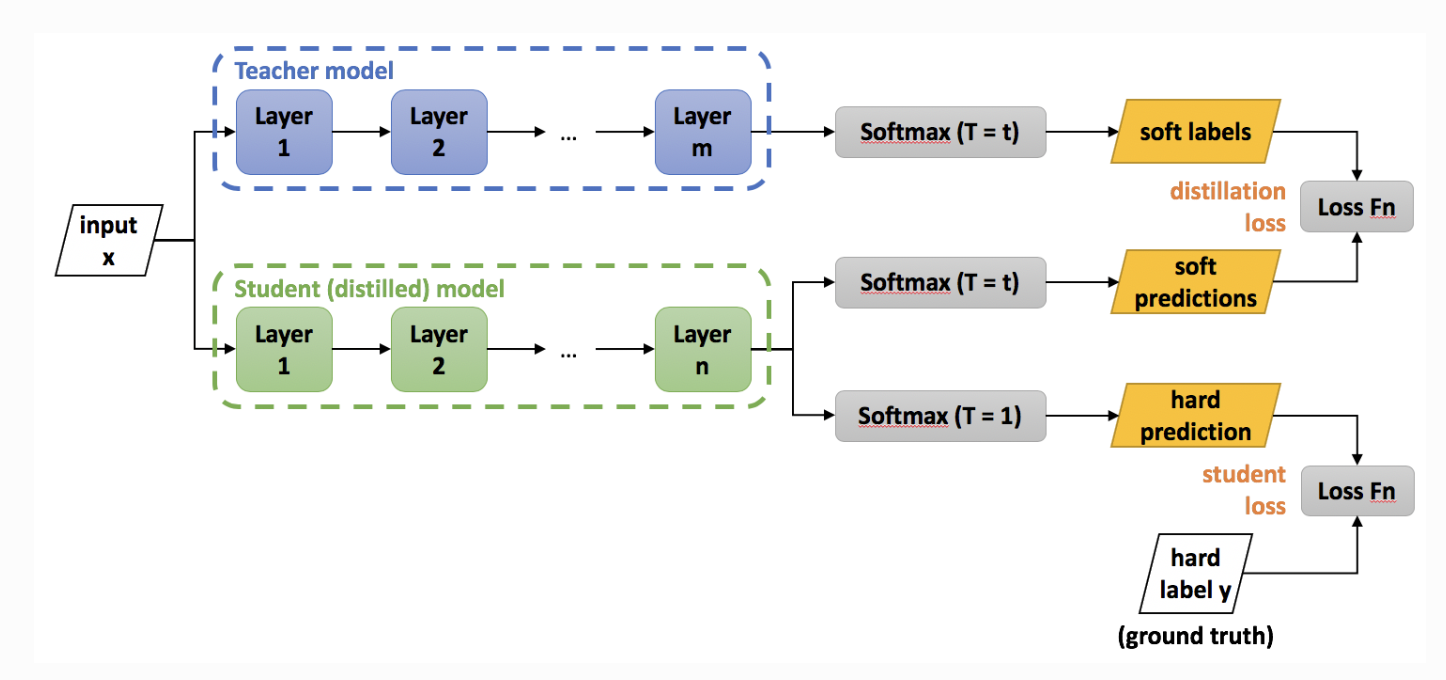

### `T5`: Multi-task Learning for Pretraining
Multi-task learning aims to train the model with better transfer learning capability.
**T5**-family is a set of models of various scales, pretrained on a diverse range of tasks including text classification, summarization, question-answering etc.

> We refer you to the original T5 paper for more details [here](https://arxiv.org/abs/1910.10683).

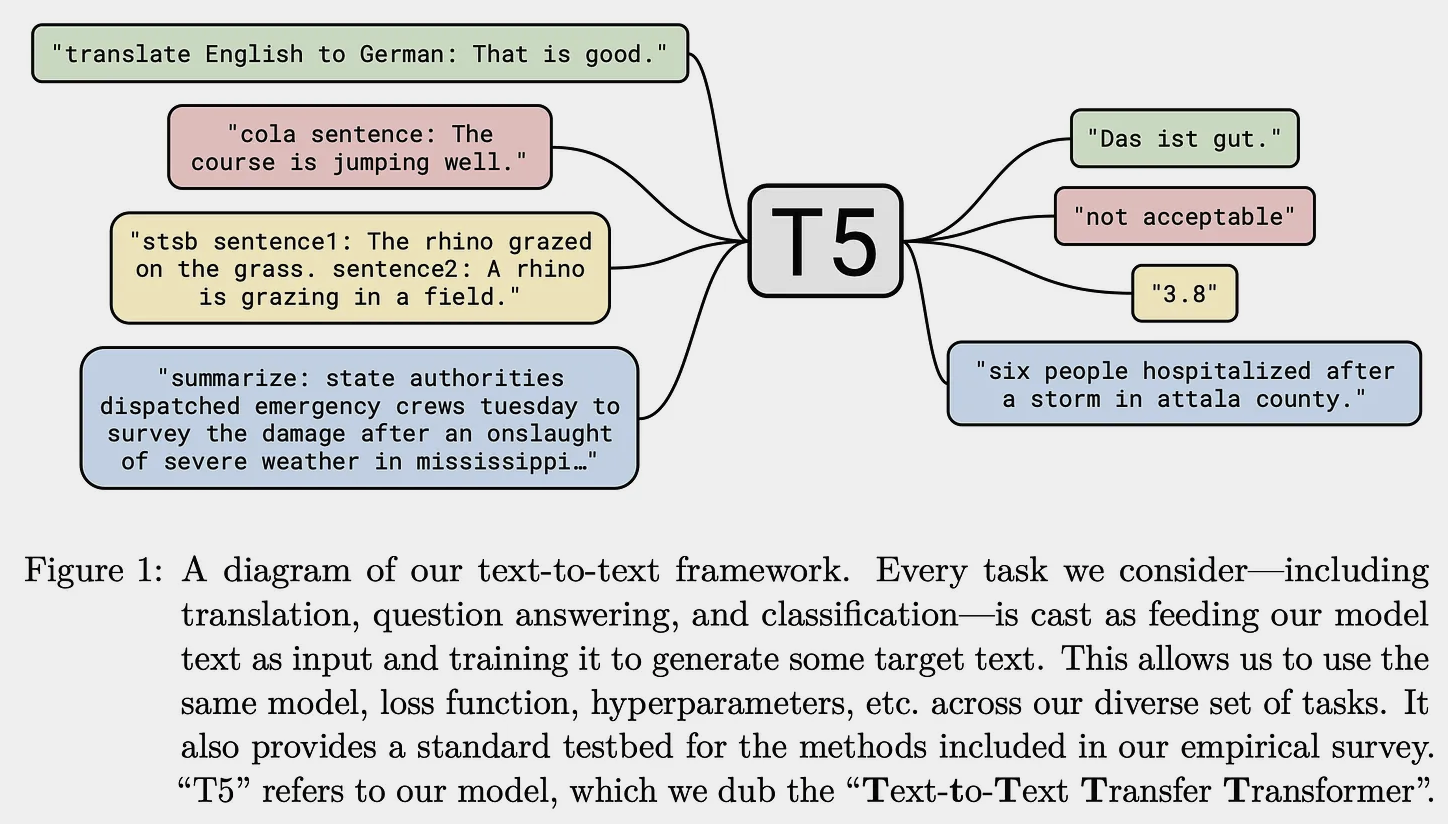

#### **Load Pretrained Models**

We can directly loaded pretrained model checkpoints from Huggingface [transformers](https://huggingface.co/docs/transformers/index), which provides access to a large variety of models.

We provide the function to load pretrained models and corresponding tokenizers provide the name/path to the huggingface checkpoint.

**`TODO-1:Load model checkpoints.`**

You are required to load `distilbert` and `t5-small` models following the given links.

In [ ]:
def load_pretrained(model_name):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name)

  if torch.cuda.is_available():
    model = model.to('cuda:0')
  return tokenizer, model

In [ ]:
# TODO: Load DistilBert (https://huggingface.co/distilbert/distilbert-base-uncased)
distilbert_tokenizer, distilbert_model = ...

# TODO: Load T5-small (https://huggingface.co/google-t5/t5-small)
t5_tokenizer, t5_model = ...

<a id=2></a>
## Task-A: Sentiment Analysis

Firstly, we will fine-tune and evaluate `distilbert` model on a movie sentiment analysis task. Specifically, we will use the [IMDB](https://huggingface.co/datasets/imdb) dataset.

**`TODO-2: Load IMDB Dataset`**


In [ ]:
def load_data(dataset_name):
  data = load_dataset(dataset_name)
  return data

# TODO: load IMDB dataset (https://huggingface.co/datasets/imdb)
imdb_data = ...

train_data = imdb_data['train']
test_data = imdb_data['test']

print('#Training samples: ', len(train_data))
print('#Test samples: ', len(test_data))

In [ ]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
# Check what is in the data loader?
for b in test_loader:
  print(b['text'])
  print(b['label'])
  break

**`TODO-3: Implement Evaluation Function`**

We first evaluate the model before fine-tuning on the subsampled `test_data`.

In [ ]:
def evaluate_model(model, tokenizer, test_loader):
  """
    Evaluates a text classification model's performance on a test dataset.
    Parameters:
    - model (torch.nn.Module): The model to be evaluated.
    - tokenizer (transformers.PreTrainedTokenizer):
        The tokenizer used to process the text data into a format that the model can
        understand.
    - test_loader (torch.utils.data.DataLoader): A DataLoader containing the test
        dataset.
    Returns:
    - all_preds (torch.Tensor): A tensor containing all the predictions made by the
        model on the test dataset.
    - all_labels (torch.Tensor): A tensor containing all the labels in the test dataset.
    - acc (float): The overall accuracy of the model on the test dataset.
    - f1 (float): The F1 score of the model on the test dataset.
  """
  all_labels = None
  all_preds = None

  for b in tqdm(test_loader):
    text = b['text']
    label = b['label']

    # TODO: tokenize the text
    inputs = ...
    if torch.cuda.is_available():
      inputs = inputs.to('cuda:0')
      label = label.to('cuda:0')

    # TODO: run the model to make the prediction
    with torch.no_grad():
        pred = ...

    if all_labels is None:
      all_labels = label.cpu()
      all_preds = pred.cpu()
    else:
      all_labels = torch.concat([all_labels, label.cpu()])
      all_preds = torch.concat([all_preds, pred.cpu()])

  assert len(all_preds)==len(all_labels), 'Test Failed. Check your code!'
  # TODO: compute f1 score between model predictions and ground-truth labels (you can use sklearn.metrics)
  f1 = ...

  # TODO: compute accuracy score between model predictions and ground-truth labels (you can use sklearn.metrics)
  acc = ...

  # TODO: compute the accuracy on Positive(label==1) samples
  pos_acc = ...

  # TODO: compute the accuracy on Negative(label==0) samples
  neg_acc = ...

  print('Accuracy: ', acc*100, '%')
  print(' -- Positive Accuracy: ', pos_acc*100, '%')
  print(' -- Negative Accuracy: ', neg_acc*100, '%')
  print('F1 score: ', f1)

  return all_preds, all_labels, acc, f1

In [ ]:
# ETS: <10mins on colab T4 gpu
all_preds, all_labels, acc, f1 = evaluate_model(distilbert_model, distilbert_tokenizer, test_loader)

**Thinking**: What do you observed from the evaluation results? Why do you think that could happen?

<a name="sent2"></a>
## A.2 Finetuned model

Now lets try to fine-tune DistilBERT on IMDB training dataset.



**`TODO-4`: Prepare the training data and data collator**

In [ ]:
# TODO: Define a function to tokenize the text
def tokenize_function(examples):
  return ...

# TODO: Tokenize the training data
tokenized_train = ...

# TODO: Define a data collator to handle padding
from transformers import DataCollatorWithPadding
data_collator = ...

**`TODO-5`: Define the `TrainingArguements` and `Trainer`.**

In [ ]:
# Import the trainer and training arguments
from transformers import TrainingArguments, Trainer

# Define the output directory and other training arguments
output_dir_name = "imdb-ft-distilbert"

training_args = TrainingArguments(
   output_dir = output_dir_name,
   learning_rate = 2e-5,
   per_device_train_batch_size = 16,
   per_device_eval_batch_size = 16,
   num_train_epochs = 1,
   weight_decay = 0.01,
   save_strategy = "epoch",
   push_to_hub = False,
)

# TODO: Initialize the trainer
trainer = Trainer(
   model = ...,
   args = ...,
   train_dataset = ...,
   tokenizer = ...,
   data_collator = ...,
   report_to = "none",
)

Start training (fine-tuning)!

In [ ]:
# ETS: ~20mins to train on colab t4 gpu
trainer.train()

Evaluate on the test set: How's the performance compared to the previous model without fine-tuning?

In [ ]:
# ETS: <10mins on colab T4 gpu
all_preds, all_labels, acc, f1 = evaluate_model(distilbert_model, distilbert_tokenizer, test_loader)

Then we can create a sentiment analysis pipeline using this finetuned model :)

In [ ]:
from transformers import pipeline

# Creating a pipeline for testing the model
distilbert_model.to('cpu')
class_labels = ['Negative', 'Positive']
distilbert_model.config.id2label = class_labels
sentiment_model = pipeline(task = 'sentiment-analysis', model = distilbert_model, tokenizer = distilbert_tokenizer)

In [ ]:
# Testing the model on a sample text
sentiment_model("I love this movie")

# TODO: Testing on your own created text
sentiment_model(...)

<a id=3></a>
## Task-B. Natural language Inference

Now we will look at a DistilBERT model which has been fine-tuned on NLI data. Specifically it has been fine-tuned on on the MNLI task of the [GLUE benchmark](https://gluebenchmark.com/).


In this dataset, the model is given a pair of sentences (`premise` and `hypothesis`). The pair has either the label "*entail*", meaning the first sentence implies the second; "*contradict*", meaning the second sentence must be false given the first; or '*neutral*", meaning you can not judge the second sentence to be true or false given the first sentence.

We first need to load the `mnli` dataset from GLUE benchmark, and build the dataloader like before:

In [ ]:
mnli = load_dataset("glue",'mnli_matched')
mnli_test = mnli["validation"]

mnli_test_loader = DataLoader(mnli_test, batch_size=16, shuffle=False)

Here, we directily load the finetuned distilbert model from huggingface.


**`TODO-6`: load the model finetuned on nli tasks from huggingface.** (https://huggingface.co/sentence-transformers/nli-distilbert-base)

In [ ]:
nli_ft_distilbert_tokenizer, nli_ft_distilbert_model = ...

**`TODO-7: Implement Evaluation Function for NLI tasks`**

what shall we change from the last version? You can look into the dataset components to see the difference.

In [ ]:
def evaluate_model_nli(model, tokenizer, test_loader):
  all_labels = None
  all_preds = None

  for b in tqdm(test_loader):
    premise = b['premise']
    hypothesis = b['hypothesis']
    label = b['label']

    # TODO: tokenize the text
    inputs = ...
    if torch.cuda.is_available():
      inputs = inputs.to('cuda:0')
      label = label.to('cuda:0')

    # TODO: run the model to make the prediction
    with torch.no_grad():
        pred = ...

    if all_labels is None:
      all_labels = label.cpu()
      all_preds = pred.cpu()
    else:
      all_labels = torch.concat([all_labels, label.cpu()])
      all_preds = torch.concat([all_preds, pred.cpu()])

  assert len(all_preds)==len(all_labels), 'Test Failed. Check your code!'
  # TODO: compute f1 score between model predictions and ground-truth labels (you can use sklearn.metrics)
  f1 = ...

  # TODO: compute accuracy score between model predictions and ground-truth labels (you can use sklearn.metrics)
  acc = ...

  # TODO: compute the accuracy on Entailment(label==0) samples
  entailment_acc = ...

  # TODO: compute the accuracy on Neutral(label==1) samples
  neutral_acc = ...
  # TODO: compute the accuracy on Contradict(label==2) samples
  contradict_acc = ...

  print('Accuracy: ', acc*100, '%')
  print(' -- Entailment Accuracy: ', entailment_acc*100, '%')
  print(' -- Neutral Accuracy: ', neutral_acc*100, '%')
  print(' -- Contradict Accuracy: ', contradict_acc*100, '%')
  print('F1 score: ', f1)

  return all_preds, all_labels, acc, f1

In [ ]:
# ETS: <1min on colab T4 gpu
all_preds, all_labels, acc, f1 = evaluate_model_nli(nli_ft_distilbert_model, nli_ft_distilbert_tokenizer, mnli_test_loader)

<a id=4></a>
## Task-C. Sentence Similarity

Next we will be using pre-trained models to perform a task that fits under the umbrella of sentence similarity. Specifically, we will be looking at **Detecting Duplicate Questions (ddp)**, in which the model needs to determine, given two questions, whether or not they are duplicates.

<a name="ss0"></a>
### `SBERT`

Unlike the previous tasks, which used token level embeddings, in order to perform this task we will use sentence level embeddings. Specifically we will be using SBERT, which was originally proposed in [this paper](https://arxiv.org/abs/1908.10084).

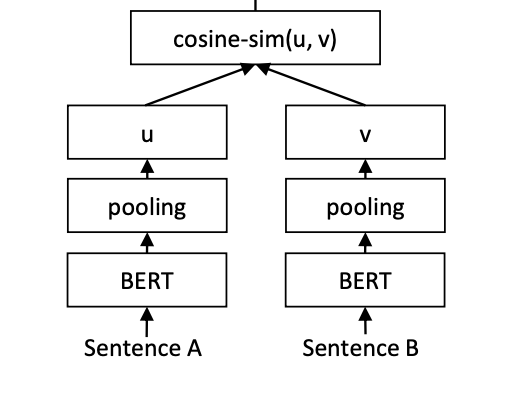

There are two important features of this model. First, on top of a transformer layer, there is a pooling layer, which pools the token level embeddings into a single sentence level embedding. Second, the network uses a siamese arctitecture. This means that the two sentences are embedded seperately from eachother. The graph in the paper can be a little misleading, at first glance it makes it appear as if sentence 1 and sentence 2 are fed into seperate BERT/pooling layers. In reality the BERT/pooling layers on either side of SBERT is the same network.

Another important thing to keep in mind is that the data was not trained on the task we are evaluating. It was trained on some NLI tasks, as well as a question answering task, but it has not seen duplicate question data.

We will be using the sentence transformer [library](https://www.sbert.net/#). The "Semantic Textual Similarity" tab on the left of their website will be the most useful in guiding you with the code.

First we import the model from `SentenceTransformer` library and load ddp data from the given `test_pairs` data file.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
quora_ddq = pd.read_excel('test_pairs.xlsx')
quora_ddq.head(10)

Then you can playwith the model!

Get a subset of the questions that will be fed into the model

In [ ]:
questions1 = quora_ddq['question1'][0:100]
questions2 = quora_ddq['question2'][0:100]

**`TODO-8: encode all the sentences with the sentencebert model`**

*Hint: you can check [`encode`](https://www.sbert.net/docs/package_reference/SentenceTransformer.html#sentence_transformers.SentenceTransformer.encode) method from `sentence-transformer`*

In [ ]:
embeddings1 = ...
embeddings2 = ...

**`TODO-9: Get the scores for each question pair.`**

You will need to:

1) recieve `cosine_similarity` score from the output.

2) choose a cutoff to decide the similarity scores above which could represent "same", not just "a bit similar".

*Hint: you can check [`util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html) method from `sentence-transformer`*

In [ ]:
# TODO: recieve cosine_similarity score from the output.
cosine_scores = ...

# TODO: choose a cutoff to decide the similarity scores above which could represent "same", not just "a bit similar".
preds = ...

Check the accuracy/F1 of the model

In [ ]:
quora_ddq_subset = pd.DataFrame(quora_ddq[0:100])
quora_ddq_subset['guess'] = preds

print("Accuracy :", accuracy_score(quora_ddq_subset['is_duplicate'], quora_ddq_subset['guess']))
print("Positive Accuracy :", accuracy_score(quora_ddq_subset[quora_ddq_subset['is_duplicate']==1]['is_duplicate'], quora_ddq_subset[quora_ddq_subset['is_duplicate']==1]['guess']))
print("Negative Accuracy :", accuracy_score(quora_ddq_subset[quora_ddq_subset['is_duplicate']==0]['is_duplicate'], quora_ddq_subset[quora_ddq_subset['is_duplicate']==0]['guess']))

print("F1 :", f1_score(quora_ddq_subset['is_duplicate'], quora_ddq_subset['guess'], average = 'micro'))


<a id=5></a>
# Task-D. Finetune mT5-Small for Machine Translation

1. **Objective**  
   - You will build on your earlier tasks by fine-tuning a multilingual T5 model on the same Week 3 machine translation dataset. 
   - Your goal is to improve the translation quality and then measure the effectiveness of your finetuned model using a machine translation metric.

2. **Data Preparation**  
   - Use the Week 3 machine translation dataset. Ensure it is properly formatted (e.g., source-target pairs) for input into a T5 model.
   - Split the dataset into training and validation sets if you have not already done so.

3. **Model Setup**  
   - Load your multilingual T5 checkpoint. Make sure to include any special tokens or prefixes (e.g., “translate <SRC_LANG> to <TGT_LANG>:”) that the model might need to correctly learn the translation task.
   - Configure hyperparameters such as the learning rate, batch size, and number of training epochs based on your available resources and the size of your dataset.

4. **Fine-tuning Procedure**  
   - Implement a training loop or use a library function (e.g., HuggingFace’s `Trainer`) to finetune the multilingual T5 model.  
   - During training, ensure you:
     - Shuffle the dataset.
     - Monitor the loss on both training and validation sets.
     - Use appropriate checkpoints or logging for progress tracking.

5. **Evaluation**  
   - After training, evaluate your final model using the provided machine translation metric.  
   - Report your metric’s score (e.g., SacreBLEU).  
   - Generate a few example translations to illustrate the model’s performance.


In [ ]:
from datasets import load_from_disk
# Load the dataset
data = load_from_disk('wmt14_fr_en_10k')
print(data)

In [ ]:
import evaluate
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

# Hint: You can use the classes imported above to complete this task

# Load the metric (SacreBLEU)
bleu_metric = evaluate.load("sacrebleu")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Convert token IDs back to text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in labels as the padding token ID, then decode
    labels = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # SacreBLEU expects a list of prediction strings, plus a list of lists for references
    results = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[lbl] for lbl in decoded_labels]
    )
    return {"bleu": results["score"]}


# TODO: Load the google/mt5-small model and tokenizer
# TODO: Tokenizer the dataset
# TODO: Define the data collator
# TODO: Define the training arguments
# TODO: Initialize the Trainer
# TODO: Train the model
# TODO: Generate some examples

# 10. Evaluate on the validation set
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)

<a name="conc"></a>
## 5. Conclusion

Congrats! Now you have seen how pretrained/finetuned `DistilBert` models have performed on a variety of tasks and finetuned multilingual T5 on a machine translation task!